# Planning for Shared Autonomous Vehicle in San Francisco 
This project studys where is the most suitable polit area for future shared autonomous vehicles system to operate in the city of San Francisoc. It studies current transportation data which has realted characteristic to SAV system, like Uber/Lyft hotspot, and other critical data for transportation planning. 

## Transit Crowding
 

In [1]:
import requests

In [2]:
import geopandas as gpd

In [3]:
import pandas as pd

In [4]:
# Download San Francisco transit crowding level data from SFTCA

url = 'https://connectsf-transitcrowding.sfcta.org/assets/connectsf/trncrowding.zip'

with open('trncrowding.zip', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [5]:
# Load the San Francisco transit crowding data as a GeoDataFrame

trncrowding = gpd.read_file('zip://trncrowding.zip')  

In [6]:
# The data for samle road segement is divided into AM and EV scenarios. This study only takes the AM data to simplify it. 
trn_am= trncrowding[(trncrowding.TP=='AM') & (trncrowding.LOAD!=0.000)]

In [7]:
trn_am.head()

,A,B,MODE,NAME,TP,LOAD,geometry
0,4000,4008,22,40_CBW,AM,0.277,"LINESTRING (6065001.695 2130313.85188, 6066666..."
2,103456,4008,22,40_CBW,AM,0.129,"LINESTRING (6064367.73359 2133807.4221, 606666..."
3,4000,13080,22,40_CBW,AM,0.129,"LINESTRING (6065001.695 2130313.85188, 6063748..."
5,4002,4026,22,40_VW,AM,0.137,"LINESTRING (6068167.11572 2127707.98838, 60690..."
6,103999,4026,18,40_18E,AM,0.005,"LINESTRING (6068042.74484 2125565.52494, 60690..."


In [8]:
trn_load = trn_am[['A','B','LOAD','geometry']].copy()

## Transit Analysis Zone
The purpose of spatialjoin these two data is to the corwding level of each TAZ. 

In [9]:
# download TAZ data from SFTCA

url = 'https://www.sfcta.org/sites/default/files/2019-06/TAZ981.zip'

with open('TAZ981.zip', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [10]:
taz = gpd.read_file('zip://TAZ981.zip')

In [11]:
taz.head()

,TAZ,geometry
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ..."
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ..."
2,3,"POLYGON ((6004983.499220342 2086750.499936027,..."
3,4,"POLYGON ((5994473.501130554 2087145.000032395,..."
4,5,"POLYGON ((6006265.000917536 2086079.750239403,..."


## Spatial Join Transit Crowding and TAZ

In [12]:
#Spatial join transit crowding level data with TAZ 

merged = gpd.sjoin(taz, trn_load, how='inner', op='intersects')

In [13]:
merged.head()

,TAZ,geometry,index_right,A,B,LOAD
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",13296,20377,20370,0.019
16,17,"POLYGON ((6007470.001622658 2087359.624800595,...",13296,20377,20370,0.019
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",13286,33605,20375,0.110
5,6,"POLYGON ((6008496.000471613 2086032.624223359,...",13286,33605,20375,0.110
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",13294,20375,33605,0.093


In [46]:
# One TAZ may have more than one transit line intersect with it. 
# Thus, data should be grouped by 'TAZ'.

merged_grp = merged.groupby(['TAZ'])
sum_lod = merged_grp['LOAD'].sum()
sum_lod = pd.DataFrame(sum_lod)

AttributeError: 'SeriesGroupBy' object has no attribute 'avg'

In [ ]:
# The length of merged data is close but smaller than the TAZ one. The reason for that is not every taz zone has a
# linestring data goes across it. 

print(len(merged))
print(len(taz))
print(len(sum_lod))

In [16]:
# Merge loading data on TAZ ID
taz_lod = taz.copy(deep=True)
taz_lod = taz_lod.merge(sum_lod, on='TAZ')
taz_lod.head()

,TAZ,geometry,LOAD
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",0.770
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",1.200
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",4.378
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",6.640
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",0.055


## Plot

In [57]:
taz_lod['AREA']=taz_lod['geometry'].area
taz_lod['LOAD_AREA']=taz_lod['LOAD']/taz_lod['AREA']

In [58]:
taz_lod.head()

,TAZ,geometry,LOAD,AREA,LOAD_AREA
0,1,"POLYGON ((6007378.500054573 2086055.37391938, ...",0.770,9.310735e+05,8.270024e-07
1,2,"POLYGON ((5992137.499592379 2086335.12355164, ...",1.200,1.825218e+06,6.574558e-07
2,3,"POLYGON ((6004983.499220342 2086750.499936027,...",4.378,1.360855e+06,3.217095e-06
3,4,"POLYGON ((5994473.501130554 2087145.000032395,...",6.640,1.596024e+06,4.160340e-06
4,5,"POLYGON ((6006265.000917536 2086079.750239403,...",0.055,1.064261e+06,5.167906e-08


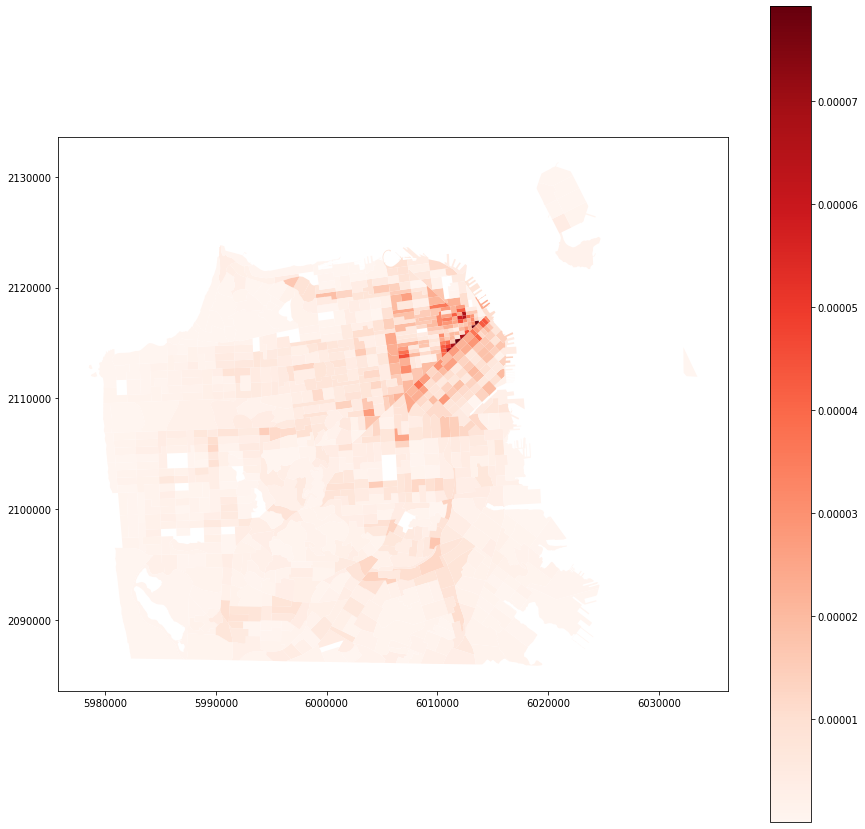

In [67]:
taz_lod.plot(column='LOAD_AREA',figsize=(15, 15),cmap='Reds',legend=True)